In [1]:
import os
import re
from typing import List, Optional

import click
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms

import legacy

import librosa
import librosa.display

import copy

from tifresi.utils import load_signal
from tifresi.utils import preprocess_signal
from tifresi.stft import GaussTF, GaussTruncTF
from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram

import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from IPython.display import Audio 
import IPython

%load_ext autoreload
%autoreload 2

In [2]:
def pghi_stft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)
    Y = stft_system.spectrogram(x)
    log_Y= log_spectrogram(Y)
    return np.expand_dims(log_Y,axis=0)
    #return log_Y
    
def rescale(data, min_val, max_val):
    return 255*(data - min_val)/(max_val - min_val)


def zeropad(signal, audio_length):
    if len(signal) < audio_length:
        return np.append(
            signal, 
            np.zeros(audio_length - len(signal))
        )
    else:
        signal = signal[0:audio_length]
        return signal
    
def pghi_istft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)

    x = np.squeeze(x,axis=0)
    new_Y = inv_log_spectrogram(x)
    new_y = stft_system.invert_spectrogram(new_Y)
    return new_y

In [3]:
network_pkl = 'training-runs/00041-vis-data-256-split-auto1-noaug/network-snapshot-002200.pkl'

reference_audio_file = '/home/purnima/appdir/Github/DATA/GreatestHitsDB/vis-data-256-split/2015-02-16-16-58-57_denoised_16.wav' 
stft_channels = 512
n_frames = 256
hop_size = 128
sample_rate = 16000

w_avg_samples = 10
num_steps=2000
initial_learning_rate = 0.1
initial_noise_factor       = 0.05
lr_rampdown_length         = 0.25
lr_rampup_length           = 0.05
noise_ramp_length          = 0.75
regularize_noise_weight    = 1e5



# Gram Matrix Loss
import metrics.gram_metrics as gram_metrics
import numpy as np

numStreams, N_FFT, K_HOP, N_FREQ, N_FILTERS, hor_filters = gram_metrics.init_params()
cnnlist = gram_metrics.get_cnn_list(numStreams, hor_filters, N_FREQ, N_FILTERS)

GPU available = True


In [4]:
def display_audio_stats(audio_file, name='', start_sec=0, end_sec=None, reduce_noise=False):
    with open(audio_file, 'rb') as f:
        y, sr = load_signal(f, sr=sample_rate)
        print('original length of audio = ', len(y))
        if end_sec is None:
            end_sec = len(y)/sample_rate
        y = y[int(start_sec*sample_rate):int(end_sec*sample_rate)]
        
        if reduce_noise:
            y = nr.reduce_noise(y=y, sr=sample_rate)
        
        print('Length of audio for stft = ', len(y))
        fig, axs = plt.subplots(ncols=3, figsize=(18,5))
        
        axs[0].plot(y)
        axs[0].set_title(name)
        IPython.display.display(IPython.display.Audio(y, rate=sample_rate))

        y = preprocess_signal(y)
        y = zeropad(y, n_frames * hop_size )
        y = pghi_stft(y)
        
        axs[1].set_title(name + ' PGHI values histogram')
        axs[1].hist(y[0].flatten())
        
        a=librosa.display.specshow(y[0],x_axis='time', y_axis='linear', ax=axs[2], sr=sample_rate, hop_length=hop_size)
        axs[2].set_title('PGHI stft')
        print(y.shape)

original length of audio =  32000
Length of audio for stft =  32000


(1, 257, 256)


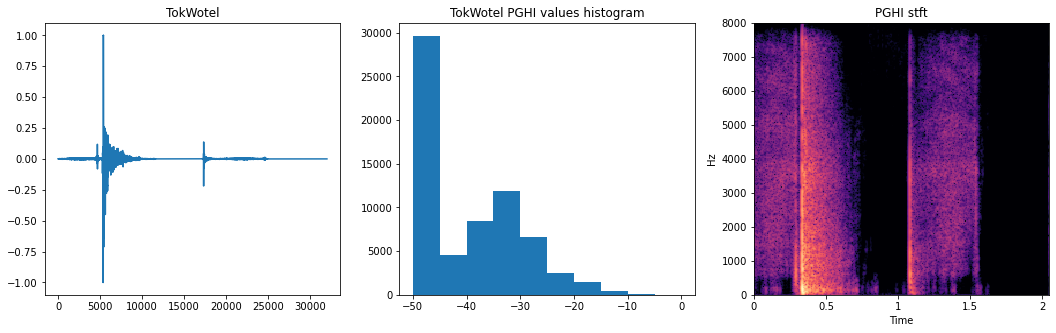

In [5]:
display_audio_stats(reference_audio_file, 'TokWotel', reduce_noise=False)

In [6]:
target, sr = load_signal(reference_audio_file, sr=sample_rate)
target = preprocess_signal(target)
target = zeropad(target, n_frames * hop_size ) #Check if you need this. Also ensure that spectrograms are eventually square.
target = pghi_stft(target)
target = rescale(target, -50, 0) # rescale to 0-255 like RGB images
target = target.astype(np.uint8)

# Shape here is 257 X 256
### WHOA! What!!!! - Did this to get the Spectrogram to 256 X 256   
target = target[:,:256,:]
target = target.repeat(3, axis=0)
target = torch.from_numpy(target)
target.shape

torch.Size([3, 256, 256])

In [7]:
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G'].to(device)
    G.eval()

In [8]:
G = copy.deepcopy(G).eval().requires_grad_(False).to(device)
z_samples = np.random.randn(w_avg_samples, G.z_dim)
w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [9]:
# Load VGG16 feature detector.
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with dnnlib.util.open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)
    
target_features = vgg16(target.unsqueeze(0).cuda(), resize_images=False, return_lpips=True)

In [10]:
# Features for target image.
target_images = target.unsqueeze(0).to(device).to(torch.float32)
if target_images.shape[2] > 256:
    target_images = F.interpolate(target_images, size=(256, 256), mode='area')

gram_list_target = []
input_img=gram_metrics.prepare_input(reference_audio_file, N_FFT, K_HOP)
result=[]
for j in range(numStreams):
    temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
gram_list_target.append(result)

In [11]:
noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

# Init noise.
for buf in noise_bufs.values():
    buf[:] = torch.randn_like(buf)
    buf.requires_grad = True
    
    
for step in range(num_steps):
    # Learning rate schedule.
    t = step / num_steps
    w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
    
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Synth images from opt_w.
    w_noise = torch.randn_like(w_opt) * w_noise_scale
    ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
    synth_images = G.synthesis(ws, noise_mode='const')
    synth_images = synth_images.repeat(1,3,1,1)

    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_images = (synth_images + 1) * (255/2)
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
    dist = (target_features - synth_features).square().sum()
    
    
    
    # Can we use Gram Matrix Loss to project into the latent space?
    
#     gram_list_synth = []
#     dc_synth_images = synth_images.detach().cpu()
#     filler = np.zeros((1,1, 1, dc_synth_images[0][0].shape[0]))
#     dc_synth_images = np.append(dc_synth_images, filler, axis=2) # UNDOING THAT CODE!
#     dc_synth_images = dc_synth_images/255
#     dc_synth_images = -50+dc_synth_images*50
#     input_img=gram_metrics.prepare_input_from_spectrum(dc_synth_images, N_FFT, K_HOP)
#     result=[]
#     for j in range(numStreams):
#         temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
#     gram_list_synth.append(result)
#     dist = gram_metrics.get_antognini_gram_loss(gram_list_target, gram_list_synth)

    
    
    
    
    # Noise regularization.
    reg_loss = 0.0
    for v in noise_bufs.values():
        noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
        while True:
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
            if noise.shape[2] <= 8:
                break
            noise = F.avg_pool2d(noise, kernel_size=2)
    loss = dist + reg_loss * regularize_noise_weight

    # Step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

    # Save projected W for each optimization step.
    w_out[step] = w_opt.detach()[0]
#     print(w_out)

    # Normalize noise.
    with torch.no_grad():
        for buf in noise_bufs.values():
            buf -= buf.mean()
            buf *= buf.square().mean().rsqrt()
w_out = w_out.repeat([1, G.mapping.num_ws, 1])

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/2000: dist 0.56 loss 17231.44
step    2/2000: dist 0.55 loss 14114.62
step    3/2000: dist 0.57 loss 13944.81
step    4/2000: dist 0.55 loss 13612.39
step    5/2000: dist 0.57 loss 13133.55
step    6/2000: dist 0.58 loss 12529.76
step    7/2000: dist 0.57 loss 11823.67
step    8/2000: dist 0.58 loss 11037.25
step    9/2000: dist 0.55 loss 10193.12
step   10/2000: dist 0.57 loss 9315.46
step   11/2000: dist 0.57 loss 8428.69
step   12/2000: dist 0.55 loss 7554.61
step   13/2000: dist 0.56 loss 6709.04
step   14/2000: dist 0.56 loss 5901.23
step   15/2000: dist 0.56 loss 5138.90
step   16/2000: dist 0.57 loss 4432.62
step   17/2000: dist 0.54 loss 3798.92
step   18/2000: dist 0.57 loss 3259.49
step   19/2000: dist 0.55 loss 2829.16
step   20/2000: dist 0.57 loss 2510.88
step   21/2000: dist 0.57 loss 2300.37
step   22/2000: dist 0.55 loss 2179.89
step   23/2000: dist 0.57 loss 2115.68
step   24/2000: dist 0.55 loss 2072.38
s

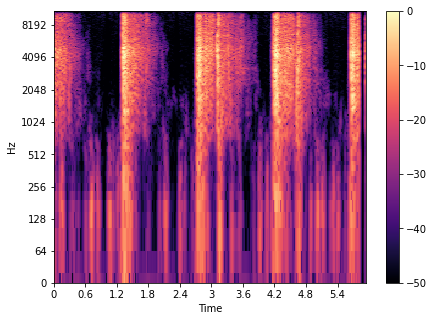

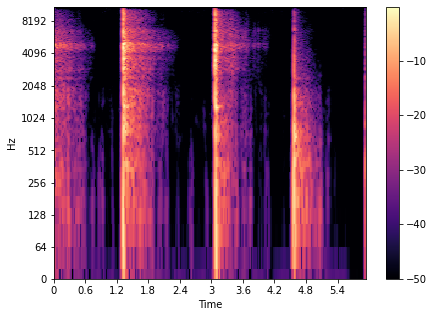

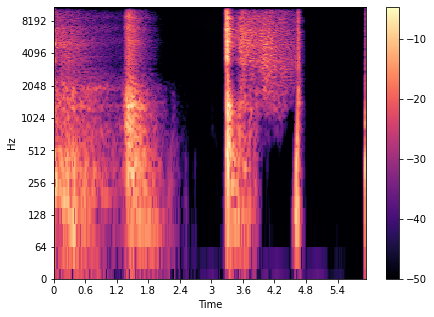

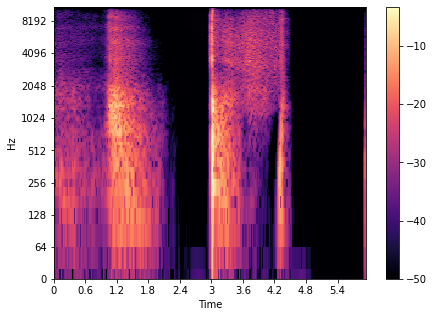

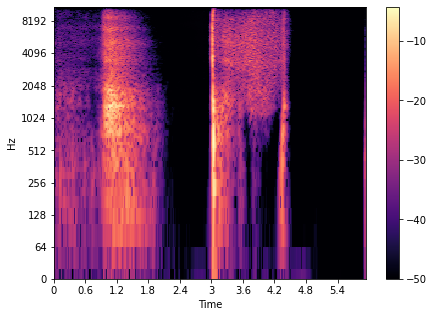

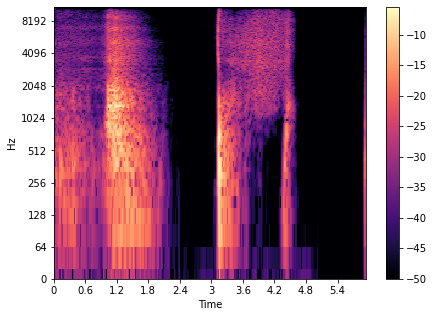

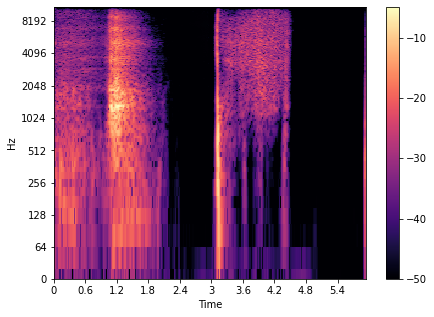

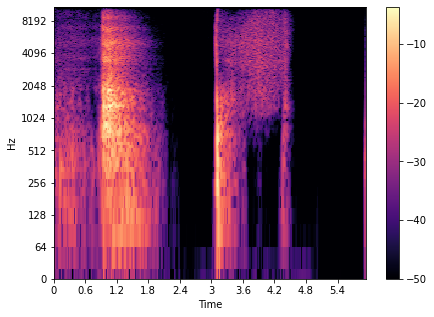

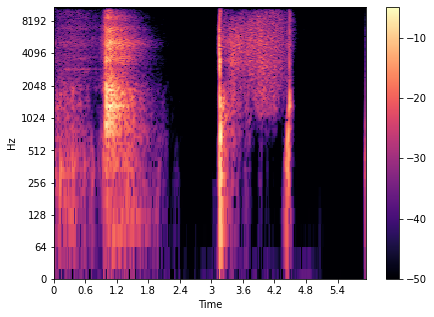

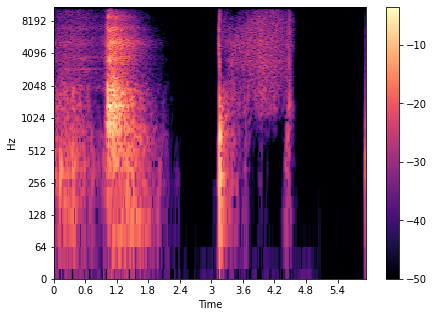

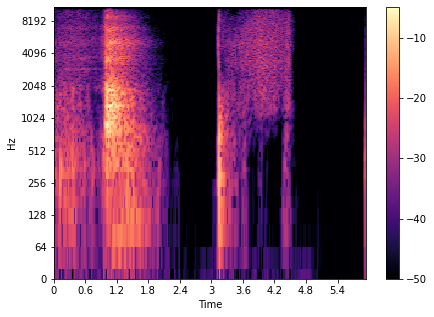

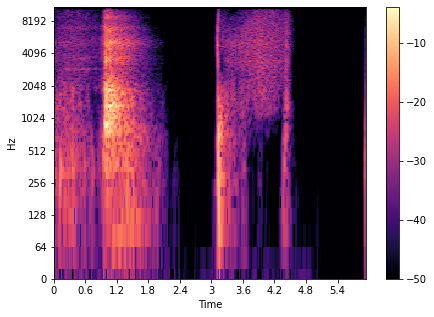

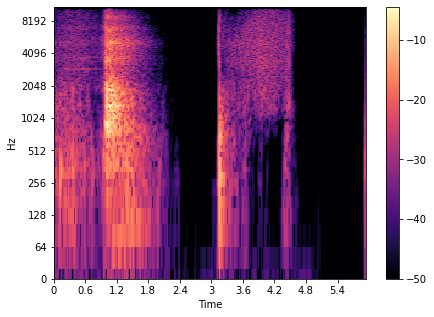

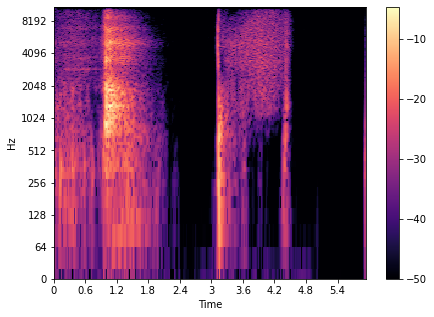

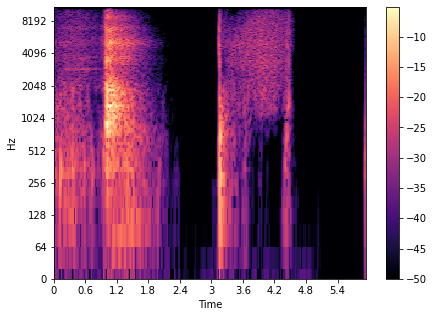

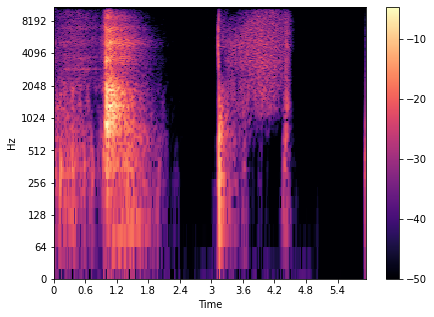

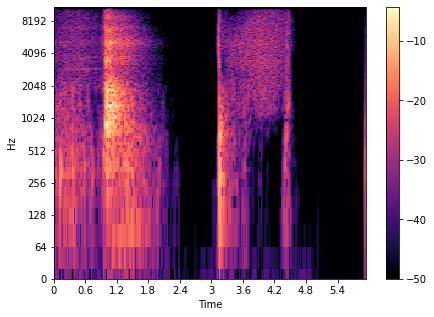

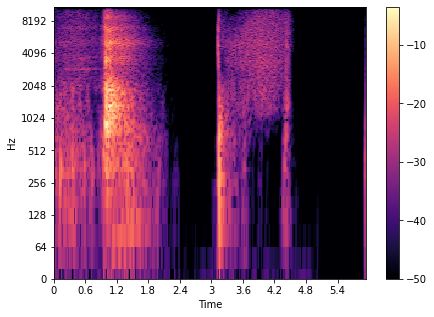

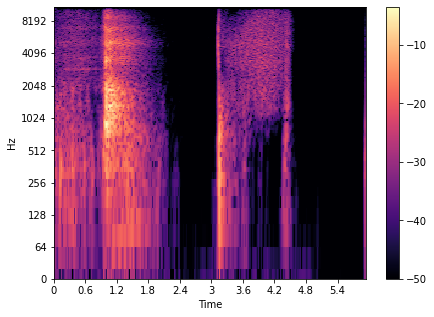

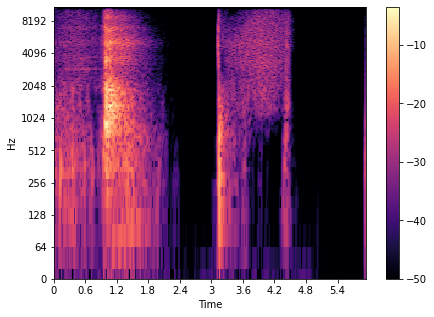

In [12]:
for ind,projected_w in enumerate(w_out):
    if ind%100==0:
        synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
        synth_image = (synth_image  * 127.5+ 128).clamp(0, 255).to(torch.uint8)
        synth_image = synth_image.detach().cpu().numpy()[0]

        filler = np.full((1, 1, synth_image[0][0].shape[0]), np.min(synth_image))
        synth_image_1 = np.append(synth_image, filler, axis=1) # UNDOING THAT CODE!
        synth_image_1 = synth_image_1/255
        synth_image_1 = -50+synth_image_1*50

        fig =plt.figure(figsize=(7, 5))
        a=librosa.display.specshow(synth_image_1[0],x_axis='time', y_axis='log')
        fig.colorbar(a)


        audio = pghi_istft(synth_image_1)
        IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))


Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


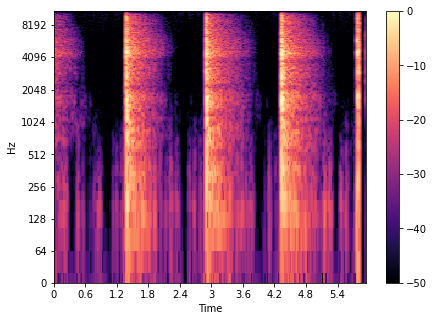

In [9]:
w_avg_samples = 100000
z_samples = np.random.randn(w_avg_samples, G.z_dim)
w_samples_1 = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
w_samples = w_samples_1[:, :1, :].cpu().numpy().astype(np.float32)   

w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

synth_image = G.synthesis(torch.from_numpy(w_avg).repeat(1, G.mapping.num_ws, 1).cuda(), noise_mode='const')
synth_image = (synth_image  * 127.5+ 128).clamp(0, 255).to(torch.uint8)
synth_image = synth_image.detach().cpu().numpy()[0]

filler = np.full((1, 1, synth_image[0][0].shape[0]), np.min(synth_image))
synth_image_1 = np.append(synth_image, filler, axis=1) # UNDOING THAT CODE!
synth_image_1 = synth_image_1/255
synth_image_1 = -50+synth_image_1*50

fig =plt.figure(figsize=(7, 5))
a=librosa.display.specshow(synth_image_1[0],x_axis='time', y_axis='log')
fig.colorbar(a)


audio = pghi_istft(synth_image_1)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))

# Can we use Gram Matrix loss during projection?

In [17]:
import metrics.gram_metrics as gram_metrics
import numpy as np

numStreams, N_FFT, K_HOP, N_FREQ, N_FILTERS, hor_filters = gram_metrics.init_params()
cnnlist = gram_metrics.get_cnn_list(numStreams, hor_filters, N_FREQ, N_FILTERS)


gram_list_1 = []
input_img=gram_metrics.prepare_input('datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-00.00--rate_exp-00.00--v-01.wav', N_FFT, K_HOP)
result=[]
for j in range(numStreams):
    temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
gram_list_1.append(result)

gram_list_2 = []
input_img=gram_metrics.prepare_input('datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-01.00--rate_exp-00.00--v-01.wav', N_FFT, K_HOP)
result=[]
for j in range(numStreams):
    temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
gram_list_2.append(result)

print('Between Wood-Metal', gram_metrics.compute_mse_distance(gram_list_1[0],gram_list_2[0]), gram_metrics.get_antognini_gram_loss(gram_list_1[0],gram_list_2[0]))


Between Wood-Metal 11.291538000106812 3.6324336093943352


In [18]:
gram_list_1 = []
input_img=gram_metrics.prepare_input('datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-01.00--rate_exp-01.00--v-01.wav', N_FFT, K_HOP)
result=[]
for j in range(numStreams):
    temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
gram_list_1.append(result)

gram_list_11 = []
input_img=gram_metrics.prepare_input('datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-01.00--rate_exp-01.00--v-01.wav', N_FFT, K_HOP)
result=[]
for j in range(numStreams):
    temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
gram_list_11.append(result)


gram_list_2 = []
input_img=gram_metrics.prepare_input('datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-00.00--rate_exp-01.00--v-01.wav', N_FFT, K_HOP)
result=[]
for j in range(numStreams):
    temp=gram_metrics.get_gram(cnnlist[j],result,input_img, None, 1, 0)
gram_list_2.append(result)



print(np.array(gram_list_1).shape, np.array(gram_list_2).shape)
# for i in range(len(gram_list)):
print('Between Wood-Metal', gram_metrics.compute_mse_distance(gram_list_1[0],gram_list_2[0]), gram_metrics.get_antognini_gram_loss(gram_list_1[0],gram_list_2[0]))
print('Between Wood-Wood', gram_metrics.compute_mse_distance(gram_list_1[0],gram_list_11[0]), gram_metrics.get_antognini_gram_loss(gram_list_1[0],gram_list_11[0]))

(1, 6, 512, 512) (1, 6, 512, 512)
Between Wood-Metal 10.135172724723816 1.0162337068331924
Between Wood-Wood 0.0 0.0
